<a href="https://colab.research.google.com/github/EnriqueGRivas/Analisis_Bluex/blob/main/PP1/8_Forecast_de_las_Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=black size = 6 face="Verdana"><center><strong>SUPPLY CHAIN ANALYTICS - Gestión Moderna de la Cadena de Suministros</center></font>


  <font color=black><center>Fecha: 04-09-2024</center>


  <font color=#48c9b0><center>Elaborado por: Mg. Ec. Enrique F. Gutierrez Rivasplata</center>

# <font color=purple><strong>Planteamiento del Problema:

BLUEX es una tienda por departamento con 3 sedes y ventas en línea que tiene operaciones en todas las regiones de Chile y Perú. Esta tienda acepta pedidos y realiza entregas en todo el Perú y se ocupa de las principales categorías de productos: Consumer, Corporate y Home Office.

Como gerente de ventas de esta tienda, debe pronosticar las ventas de los productos para los próximos 6 meses, de modo que tenga una estimación adecuada y pueda planificar su inventario y procesos comerciales en consecuencia.

### **Importando Paquetes:**

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Establecer gráficos con un mejor estilo
# ==============================================================================
plt.style.use('seaborn-whitegrid')
sns.set(style="ticks")

# Configuración del Forecast
# ==============================================================================
!pip install statsmodels
from matplotlib import rcParams
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


<a id='part1'></a>
## <font color=#ba4a00><strong>Lectura y Comprensión de los Datos:

In [ ]:
from google.colab import files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leer el archivo Excel con los datos simulados
# ==============================================================================
data = pd.read_excel('/content/drive/MyDrive/Análisis - Python/DATOS/Data1.xlsx')


# Copiamos el dataframe
# ==============================================================================
retail = data.copy()

# Mostrar las primeras filas del dataframe
# ==============================================================================
retail.head()

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingresos_por_Distribucion_SDD,Ingresos_por_Falsos_Fletes,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica
0,2015-01-03,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,66603.25,0.0,349.650000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385
1,2015-01-03,2204384,3112,1097514,Shipping,Standard Class,EMP-20449216343,2015-01-05,2015-01-05,27,...,3379.95,0.0,413.696970,194.472935,49.0,344.747475,663.329501,3379.95,70.425,4113.704501
2,2015-01-03,2204387,3115,204754,Shipping,Standard Class,CON-10004331147,2015-01-05,2015-01-05,22,...,66150.00,0.0,8.910000,4.188462,11.8,7.425000,14.286462,66150.00,4488.750,70653.036462
3,2015-01-03,2204382,3110,1001830,Shipping,Standard Class,CON-10181604579,2015-01-05,2015-01-06,90,...,0.00,32387.4,137.576863,64.672884,19.2,114.647385,220.593328,21752.75,32387.400,54360.743328
4,2015-01-05,2204395,3123,1001830,Shipping,Standard Class,EMP-20447989051,2015-01-06,2015-01-06,81,...,30453.85,32387.4,137.576863,64.672884,19.2,114.647385,220.593328,30453.85,32387.400,63061.843328


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print("La cantidad de columnas es: ",retail.shape[1])
print("La cantidad de filas es: ",retail.shape[0])

La cantidad de columnas es:  81
La cantidad de filas es:  26162


In [ ]:
# Identificamos la cantidad de NANs en cada función y seleccione solo aquellas que tienen NANs
# ==============================================================================
total_NA = retail.isnull().sum()[retail.isnull().sum() != 0]

# Calculamos el porcentaje de NANs en cada característica
# ==============================================================================
percent_NA = retail.isnull().sum()[retail.isnull().sum() != 0]/retail.shape[0]

# Resumen de nuestros hallazgos en un Data Frame
# ==============================================================================
missing = pd.concat([total_NA, percent_NA], axis=1, keys=['Total NANs', 'Porcentaje']).sort_values('Total NANs', ascending=False)
missing

,Total NANs,Porcentaje
Proceso_Devol,21535,0.82314
Cod_Cliente_Devol,21535,0.82314


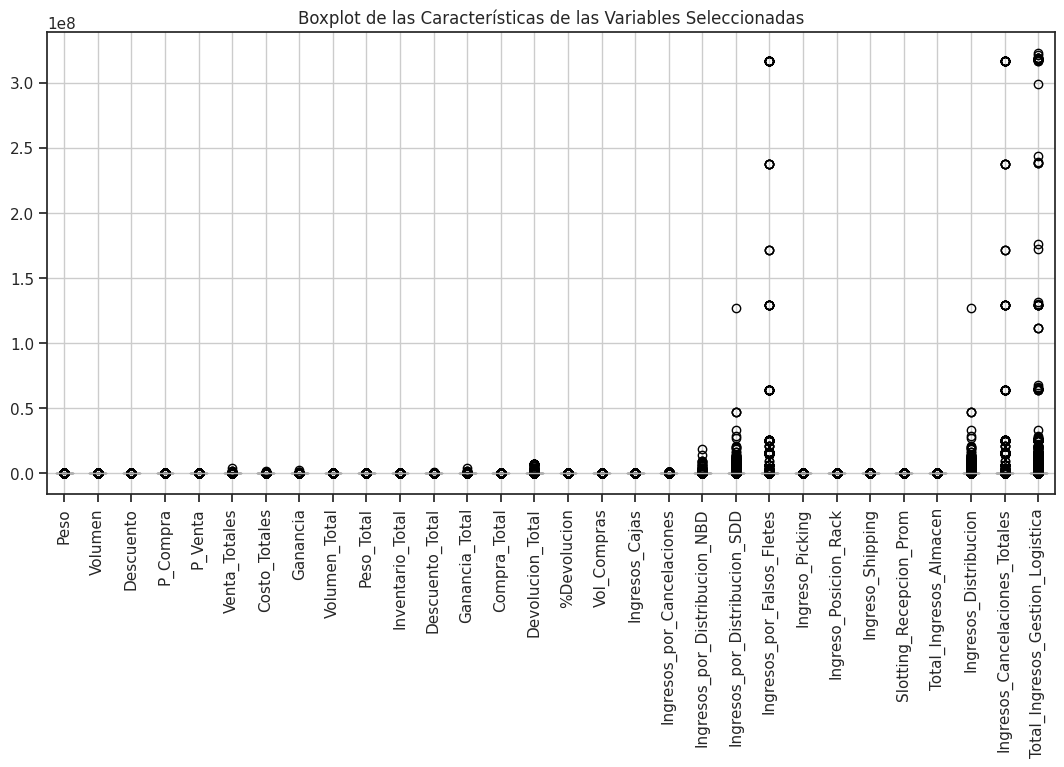

,count,mean,std,min,25%,50%,75%,max
Peso,26162.0,6.01,10.65,0.00,0.48,2.46,6.03,1.455000e+02
Volumen,26162.0,0.07,0.11,0.00,0.03,0.03,0.07,3.890000e+00
Descuento,26162.0,0.13,0.19,0.00,0.00,0.00,0.20,8.000000e-01
P_Compra,26162.0,283.15,528.59,0.02,12.69,93.65,350.11,1.717421e+04
P_Venta,26162.0,610.17,1023.83,0.03,34.95,207.35,849.50,2.763728e+04
Venta_Totales,26162.0,6594.40,36388.52,0.00,187.25,898.50,3747.50,3.625779e+06
Costo_Totales,26162.0,3193.93,16651.78,0.00,70.25,352.32,1569.33,1.382177e+06
Ganancia,26162.0,3400.47,20859.86,-2260.70,79.12,396.01,1756.00,2.243602e+06
Volumen_Total,26162.0,0.74,2.51,0.00,0.09,0.18,0.48,1.031400e+02
Peso_Total,26162.0,63.77,266.77,0.00,1.68,9.24,38.03,1.353150e+04


In [ ]:
# Explorando las características de las variables (Boxplot de las características)
# ===================================================================================
plt.figure(figsize=(13, 6))
# Convert the Index to a list of strings
variables = retail.loc[:, retail.dtypes == "float64"].columns.tolist()
retail.boxplot(column=variables)
plt.title('Boxplot de las Características de las Variables Seleccionadas')
plt.xticks(rotation=90)
plt.show()

# Resumen estadístico de las características
# ===================================================
retail[variables].describe().transpose().round(2)

# <font color=purple><strong>Preparación de Datos:

### <font color=blue>Crear una nueva columna "Market_Segment"

In [ ]:
# Procedemos a Separar las 3 primeras Letras de la Columna "Cod_Cliente"
# ==============================================================================
retail['Cod_Segment'] = retail['Cod_Cliente'].str[:3]
retail.head(3)

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingresos_por_Falsos_Fletes,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica,Cod_Segment
0,2015-01-03,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,0.0,349.65000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385,CON
1,2015-01-03,2204384,3112,1097514,Shipping,Standard Class,EMP-20449216343,2015-01-05,2015-01-05,27,...,0.0,413.69697,194.472935,49.0,344.747475,663.329501,3379.95,70.425,4113.704501,EMP
2,2015-01-03,2204387,3115,204754,Shipping,Standard Class,CON-10004331147,2015-01-05,2015-01-05,22,...,0.0,8.91000,4.188462,11.8,7.425000,14.286462,66150.00,4488.750,70653.036462,CON


In [ ]:
# Procedemos a crear la columna "Market_segment"
# ==============================================================================
retail['Market_Segment']= retail['Cod_Segment']+'_' +retail['Zona']
retail.head()

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica,Cod_Segment,Market_Segment
0,2015-01-03,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,349.650000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385,CON,CON_Lima Centro
1,2015-01-03,2204384,3112,1097514,Shipping,Standard Class,EMP-20449216343,2015-01-05,2015-01-05,27,...,413.696970,194.472935,49.0,344.747475,663.329501,3379.95,70.425,4113.704501,EMP,EMP_Lima Centro
2,2015-01-03,2204387,3115,204754,Shipping,Standard Class,CON-10004331147,2015-01-05,2015-01-05,22,...,8.910000,4.188462,11.8,7.425000,14.286462,66150.00,4488.750,70653.036462,CON,CON_Lima Centro
3,2015-01-03,2204382,3110,1001830,Shipping,Standard Class,CON-10181604579,2015-01-05,2015-01-06,90,...,137.576863,64.672884,19.2,114.647385,220.593328,21752.75,32387.400,54360.743328,CON,CON_Lima Centro
4,2015-01-05,2204395,3123,1001830,Shipping,Standard Class,EMP-20447989051,2015-01-06,2015-01-06,81,...,137.576863,64.672884,19.2,114.647385,220.593328,30453.85,32387.400,63061.843328,EMP,EMP_Lima Centro


In [ ]:
# Verificamos cuantas items únicos cuenta cada una de las columnas
# ==============================================================================
retail.nunique().sort_values(ascending=True).head(10)

,0
Proceso,1
Estado_Civil,2
Canal_Venta,2
Proceso_Devol,2
UM,2
Genero,2
Prioridad_Pedido,2
Segmento,3
Cod_Segment,3
Year,3


In [ ]:
# Pasamos a ver solo las variables Categóricas de tipo "Object"
# ==============================================================================
#retail.select_dtypes(include='object').head()
categorical_vars = retail.select_dtypes(include=['object'])
categorical_vars.nunique().sort_values(ascending=True)

,0
Proceso,1
Canal_Venta,2
UM,2
Estado_Civil,2
Proceso_Devol,2
Genero,2
Prioridad_Pedido,2
Segmento,3
Cod_Segment,3
Operador,4


- <font color=green>Podemos ver que la tienda atiende a 6 zonas de Lima como segmentos de mercado geográficos diferentes y 3 tipos de productos principales.
- <font color=green>Hay 13 "Segmentos de Mercado (Market_Segment)" únicos.

### <font color=blue>Veamos cuáles son los Segmentos de mercado únicos, en las Principales zonas de Distribución de acuerdo al Segmentos de Mercado.

Zona
Lima Oeste       15257
Lima Centro       8930
Metropolitano     1509
Lima Este          259
Lima Norte         134
Lima Sur            73
Name: count, dtype: int64


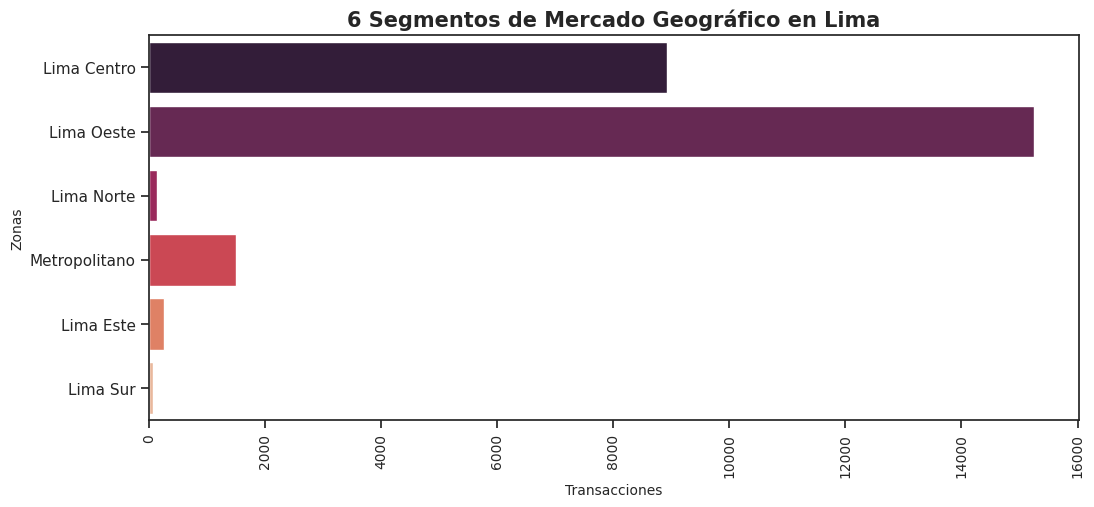

In [ ]:
# Regiones Geograficas donde Opera Bluex
# ==============================================================================
plt.figure(figsize=(12,5))
print(retail.Zona.value_counts())
sns.countplot(retail['Zona'], palette='rocket')
plt.title('6 Segmentos de Mercado Geográfico en Lima', fontweight='bold', size=15)
plt.xlabel('Transacciones', fontsize=10)
plt.ylabel('Zonas', fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.show()

Segmento
Consumer       13338
Corporate      11563
Home Office     1261
Name: count, dtype: int64


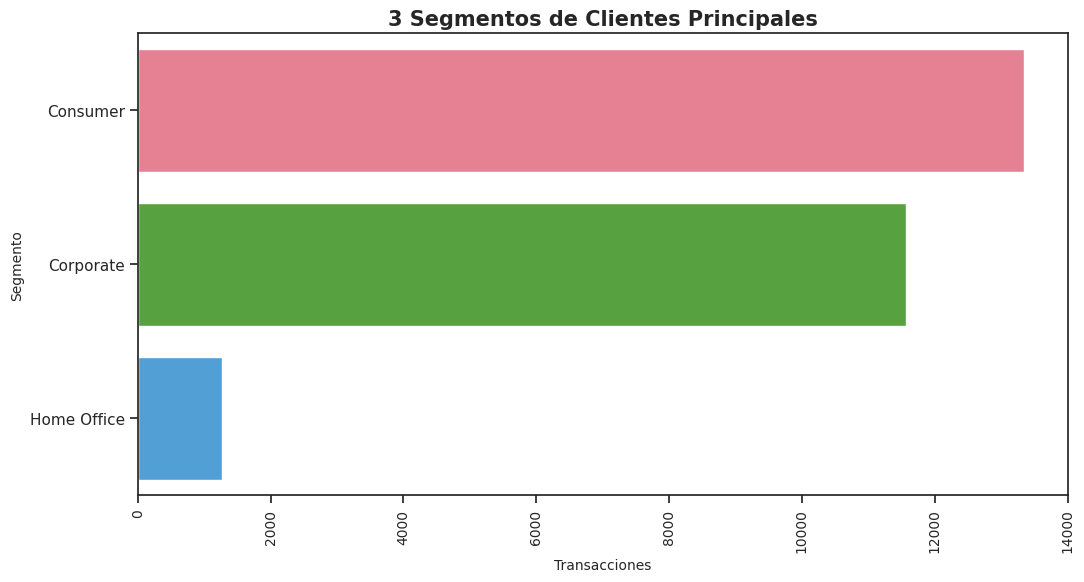

In [ ]:
# Principales Segmentos de Mercado
# ==============================================================================
plt.figure(figsize=(12,6))
print(retail.Segmento.value_counts())
sns.countplot(retail['Segmento'], palette='husl')
plt.title('3 Segmentos de Clientes Principales',fontweight='bold', size=15)
plt.xlabel('Transacciones', fontsize=10)
plt.ylabel('Segmento', fontsize=10)
plt.xticks(rotation=90, fontsize=10)
plt.show()

Market_Segment
CON_Lima Oeste       8983
RET_Lima Oeste       5952
CON_Lima Centro      3926
RET_Lima Centro      2558
EMP_Lima Centro      2446
CON_Metropolitano    1471
EMP_Lima Oeste        322
EMP_Lima Este         178
CON_Lima Este          81
CON_Lima Sur           73
EMP_Lima Norte         69
CON_Lima Norte         65
EMP_Metropolitano      38
Name: count, dtype: int64


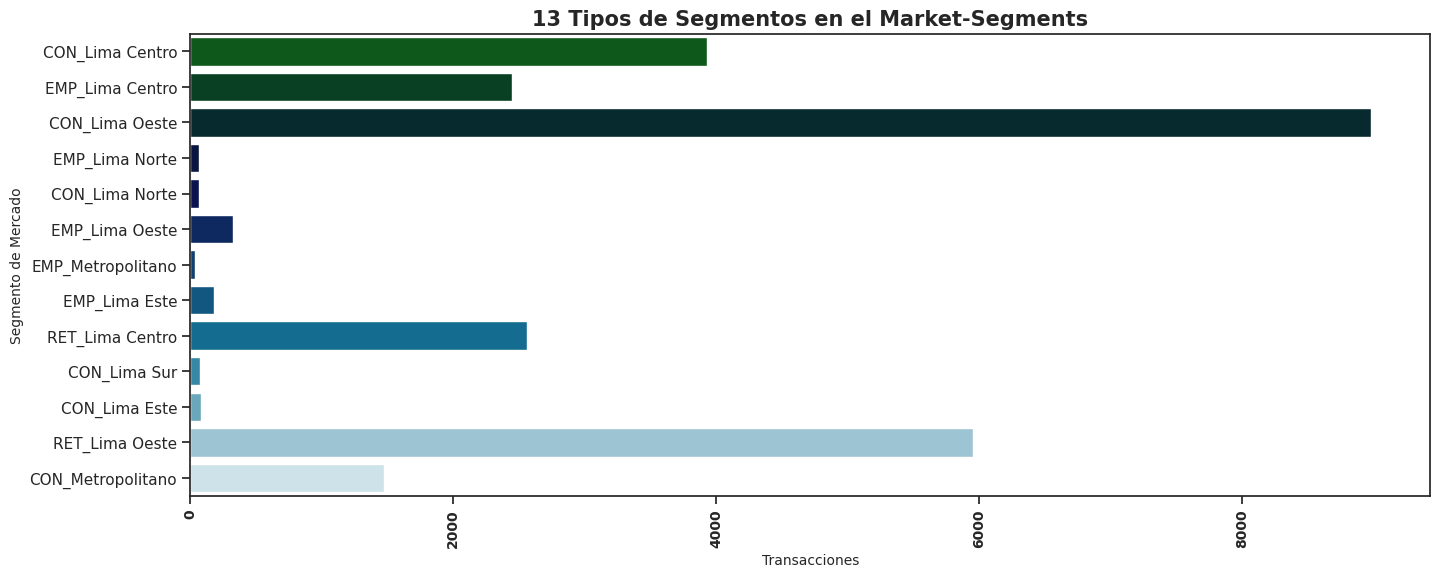

In [ ]:
# Los 208 Tipo de Producto que opera en cada Segmento de Mercado
# ==============================================================================
plt.figure(figsize=(16,6))
print(retail.Market_Segment.value_counts())
sns.countplot(retail['Market_Segment'], palette='ocean')
plt.title('13 Tipos de Segmentos en el Market-Segments',fontweight='bold', size=15)
plt.xlabel('Transacciones', fontsize=10)
plt.ylabel('Segmento de Mercado', fontsize=10)
plt.xticks(rotation = 90,fontweight="bold",fontsize=10)
plt.show()

<font color=green> Podemos ver en el gráfico que CON_Lima Oeste tiene el recuento más alto, con 8983 transacciones en la zona.

### <font color=blue> Market_Segment vs Ventas Brutas (Utilidad)

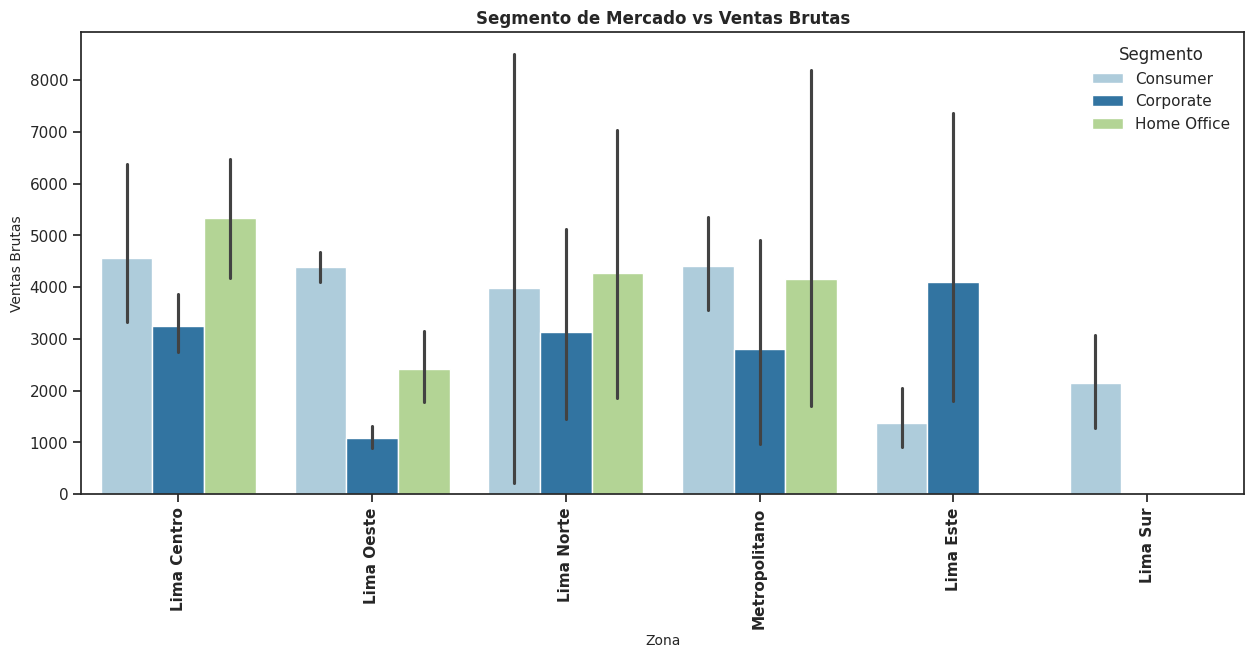

In [ ]:
# Market_Segment vs Ventas Brutas
# ==============================================================================
plt.figure(figsize=(15,6))
sns.barplot(x='Zona', y= 'Ganancia', hue='Segmento', data=retail, palette='Paired')
plt.title('Segmento de Mercado vs Ventas Brutas', fontweight='bold')
plt.xlabel('Zona', fontsize=10)
plt.ylabel('Ventas Brutas', fontsize=10)
plt.xticks(rotation = 90,fontweight="bold")
plt.show()

- <font color=green> Podemos ver que los mercados de Lima Centro, Norte y Metropolitana con los segmentos Consumo, Corporativo y Oficina del Hogar tienen más Utilidad.
- <font color=green> Los segmentos de Lima Sur y Lima Oeste tienen menos Utilidad.

### <font color=blue> Market_Segment vs Ventas Totales

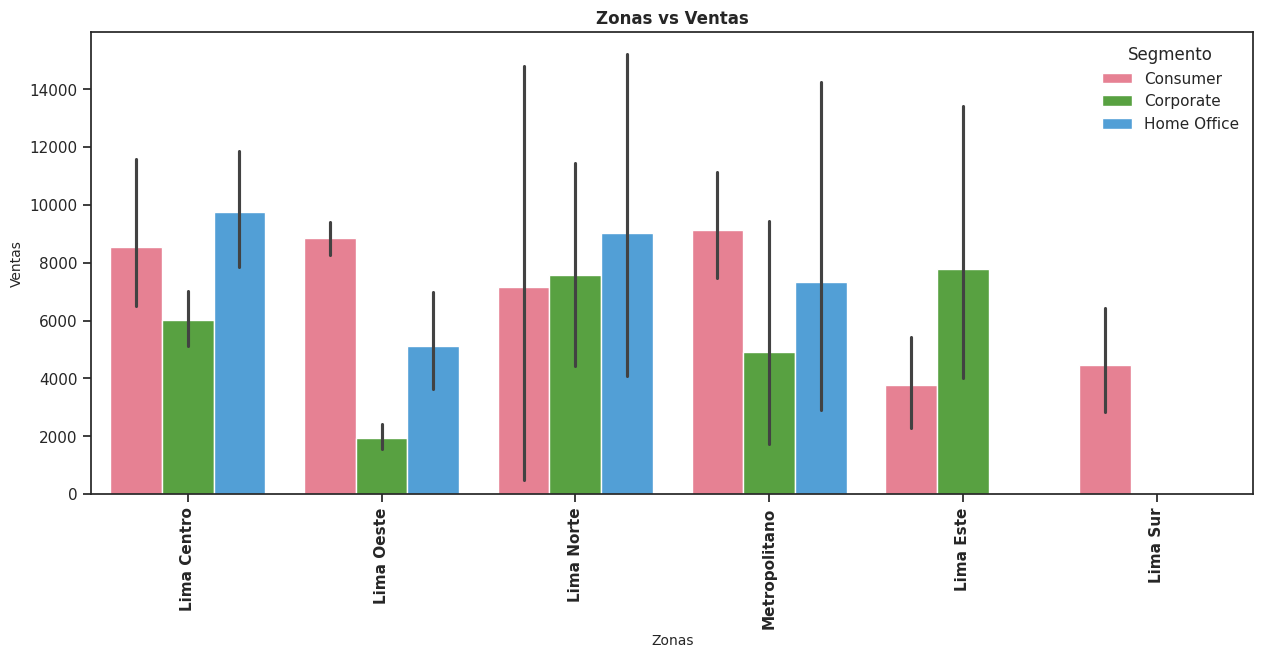

In [ ]:
# Market_Segment vs Ventas Totales
# ==============================================================================
plt.figure(figsize=(15,6))
sns.barplot(x='Zona', y= 'Venta_Totales', hue='Segmento', data=retail, palette='husl')
plt.title('Zonas vs Ventas', fontweight='bold')
plt.xlabel('Zonas', fontsize=10)
plt.ylabel('Ventas', fontsize=10)
plt.xticks(rotation = 90,fontweight="bold")
plt.show()

- <font color=green> Los mercados Lima Norte y Metropolitano tiene mayores ventas en los tres segmentos.
- <font color=green> Lima Sur y Lima Oeste tienen menos ventas.  

### <font color=blue> Convertimos la fecha del pedido a un formato de fecha y hora

In [ ]:
# Convertimos la fecha del pedido a un formato de fecha y hora para obtener el formato mes-año
# ==============================================================================
retail['F_Orden'] = pd.to_datetime(retail['F_Orden']).dt.to_period('m')
retail= retail.sort_values(by=['F_Orden'])
retail.head()

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica,Cod_Segment,Market_Segment
0,2015-01,2204383,3111,204978,Shipping,Standard Class,CON-10004331147,2015-01-03,2015-01-03,80,...,349.650000,164.365385,223.8,291.375000,560.635385,66603.25,528.600,67692.485385,CON,CON_Lima Centro
338,2015-01,2204702,3430,1002220,Shipping,First Class,CON-10200520136,2015-01-28,2015-01-28,19,...,26.800688,12.598614,4.0,22.333906,42.972726,2692.20,214.925,2950.097726,CON,CON_Lima Centro
337,2015-01,2204703,3431,1003440,Shipping,Same Day,EMP-20489696313,2015-01-28,2015-01-28,22,...,103.500000,48.653846,12.0,86.250000,165.953846,31465.00,786.625,32417.578846,EMP,EMP_Lima Centro
336,2015-01,2204704,3432,1096542,Shipping,Same Day,CON-71831647,2015-01-28,2015-01-28,3,...,2.032190,0.955303,0.2,1.693492,3.258452,440.30,581.700,1025.258452,CON,CON_Lima Centro
335,2015-01,2204704,3432,1096541,Shipping,Same Day,CON-71831647,2015-01-28,2015-01-28,3,...,1.920000,0.902564,0.2,1.600000,3.078564,62964.65,58467.175,121434.903564,CON,CON_Lima Centro


###  <font color=blue> Datos de Transacciones agregadas mensuales

In [ ]:
# Agregados Mensuales
# ==============================================================================
retail_sales = retail.pivot_table(index ='F_Orden',values ='Venta_Totales', columns ='Market_Segment',aggfunc ='sum')
retail_sales.head()

Market_Segment,CON_Lima Centro,CON_Lima Este,CON_Lima Norte,CON_Lima Oeste,CON_Lima Sur,CON_Metropolitano,EMP_Lima Centro,EMP_Lima Este,EMP_Lima Norte,EMP_Lima Oeste,EMP_Metropolitano,RET_Lima Centro,RET_Lima Oeste
F_Orden,,,,,,,,,,,,,
2015-01,4690923.98,19815.20,55178.01,63380.07,35691.50,NaN,3086263.41,443133.57,9299.58,30998.47,20473.85,12270.50,NaN
2015-02,2734513.76,4542.50,47349.16,149640.26,64828.74,NaN,2512996.54,142585.79,1180.00,247404.40,33278.00,45985.72,895783.71
2015-03,1074586.29,3237.75,NaN,21734.38,48905.09,119128.0,1091670.29,27200.88,3070.00,130766.40,1799.80,22459.50,120594.55
2015-04,1270774.56,5436.28,NaN,511435.60,NaN,40190.0,2610160.73,47605.56,58496.88,100156.41,18251.06,NaN,51033.75
2015-05,406993.73,29389.50,2394.00,60283.84,98.04,61747.5,1251673.10,16272.15,67641.00,68677.00,405.79,NaN,NaN


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print("La cantidad de columnas es: ",retail_sales.shape[1])
print("La cantidad de filas es: ",retail_sales.shape[0])

La cantidad de columnas es:  13
La cantidad de filas es:  36


<font color=green> Obtuvimos los datos de 36 meses (3 años) para los 21 segmentos de mercado.

# <font color=purple><strong> División de los datos Test - Train

In [ ]:
# Realizamos la división Train-test de manera que tome los 30 meses como datos del Train y los 6 meses como datos de prueba.
# ==============================================================================
train_len = 30
train = retail_sales[0:train_len] # Primeros 30 meses como conjunto de entrenamiento
test = retail_sales[train_len:] # Últimos 6 meses como conjunto de prueba

In [ ]:
# Verificamos cuantas filas y columnas cuenta nuestra datos de Entrenamiento
# ==============================================================================
train.shape

(30, 13)

In [ ]:
# Una muestra de los datos
# ==============================================================================
train.head()

Market_Segment,CON_Lima Centro,CON_Lima Este,CON_Lima Norte,CON_Lima Oeste,CON_Lima Sur,CON_Metropolitano,EMP_Lima Centro,EMP_Lima Este,EMP_Lima Norte,EMP_Lima Oeste,EMP_Metropolitano,RET_Lima Centro,RET_Lima Oeste
F_Orden,,,,,,,,,,,,,
2015-01,4690923.98,19815.20,55178.01,63380.07,35691.50,NaN,3086263.41,443133.57,9299.58,30998.47,20473.85,12270.50,NaN
2015-02,2734513.76,4542.50,47349.16,149640.26,64828.74,NaN,2512996.54,142585.79,1180.00,247404.40,33278.00,45985.72,895783.71
2015-03,1074586.29,3237.75,NaN,21734.38,48905.09,119128.0,1091670.29,27200.88,3070.00,130766.40,1799.80,22459.50,120594.55
2015-04,1270774.56,5436.28,NaN,511435.60,NaN,40190.0,2610160.73,47605.56,58496.88,100156.41,18251.06,NaN,51033.75
2015-05,406993.73,29389.50,2394.00,60283.84,98.04,61747.5,1251673.10,16272.15,67641.00,68677.00,405.79,NaN,NaN


## <font color=purple> Calculamos la CoV sobre las Ventas para cada uno de los 13 segmentos de mercado en los datos del Train.

- Comparamos la varianza entre los segmentos utilizando el coeficiente de variación que normalizará la desviación estándar con la media y dará una cifra comparativa a partir de la cual podemos identificar el segmento de mercado más rentable.
- Queremos pronosticar las ventas donde el segmento de mercado es confiable o en otras palabras, hay menos variación en las Ventas.

In [ ]:
# Creamos las Variables para el Análisis Correspondiente
# ==============================================================================
mean = train.mean() # Calcular la media para cada columna.
std = train.std() # Calcular la desviación estándar para cada columna.

CoV_df = pd.DataFrame(mean)
CoV_df['std']= std
CoV_df['CoV'] = std/mean
CoV_df = CoV_df.reset_index()
CoV_df.columns = ['Market_Segment', 'Mean', 'Std', 'CoV']
CoV_df.sort_values(by ='CoV', ascending = True, inplace = True)
CoV_df

,Market_Segment,Mean,Std,CoV
2,CON_Lima Norte,6.390702e+04,5.215523e+04,0.816111
6,EMP_Lima Centro,1.557606e+06,1.417573e+06,0.910097
4,CON_Lima Sur,4.078383e+04,3.964599e+04,0.972101
9,EMP_Lima Oeste,9.991568e+04,9.794471e+04,0.980274
5,CON_Metropolitano,2.532095e+05,2.559420e+05,1.010791
3,CON_Lima Oeste,1.306212e+06,1.448801e+06,1.109162
8,EMP_Lima Norte,5.236302e+04,6.086891e+04,1.162441
1,CON_Lima Este,3.054173e+04,3.955494e+04,1.295111
7,EMP_Lima Este,1.388010e+05,1.837886e+05,1.324115
0,CON_Lima Centro,1.018087e+06,1.426779e+06,1.401432


In [ ]:
# Extraemos el Max y Min de los Resultados obtenidos
# ==============================================================================
Bajo_CoV_value = min(CoV_df["CoV"])
print("La COV mas Baja es: ",Bajo_CoV_value)

Alto_CoV_value = max(CoV_df["CoV"])
print("La COV mas Alta es: ",Alto_CoV_value)


La COV mas Baja es:  0.8161110777604609
La COV mas Alta es:  2.0927276610571752


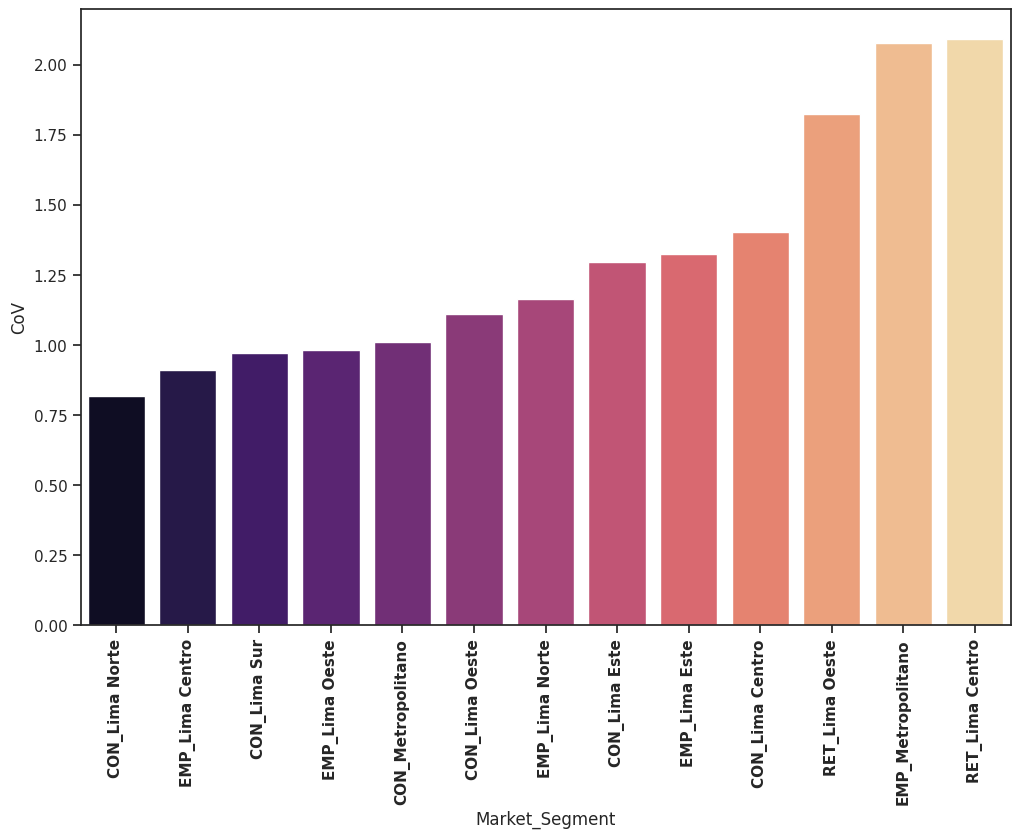

In [ ]:
# Vamos a realizar de manera ascendente
# ==============================================================================
sns.barplot(x='Market_Segment', y= 'CoV', data = CoV_df, palette='magma')
plt.xticks(rotation = 90,fontweight = "bold")
plt.show()

- <font color=green> Podemos ver que el CoV más bajo es 0.8161.
- <font color=green> Podemos inferir que el segmento Marget correspondiente es "CON_Lima Norte"
- <font color=green> El segmento de mercado más rentable es "CON_Lima Norte"

## <font color=purple> Convertimos la columna "F_Orden" de "DateTime" a "timestamp"

In [ ]:
# Verificamos el tipo de dato
# ==============================================================================
retail['F_Orden'].dtype

period[M]

In [ ]:
# Convertimos a variable
# ==============================================================================
retail['F_Orden'] = retail['F_Orden'].astype(str)
retail['F_Orden'] = pd.to_datetime(retail['F_Orden'])

retail['F_Orden'].dtype

dtype('<M8[ns]')

- <font color=green> Por lo tanto, ahora también obtendrá una marca de tiempo para cada fecha de pedido.

## <font color=purple> Filtramos los datos para obtener el mejor segmento de mercado: CON_Lima Norte

In [ ]:
# Elimine los datos de los 20 segmentos de mercado restantes y conserve solo los del segmento de mercado.
# que usted encontró que era el más consistentemente rentable.
# ==============================================================================
retail_df = retail[(retail.Market_Segment=='CON_Lima Oeste')] # Vamos a utilizar esta variable como muestra para el análisis
retail_df.head()

,F_Orden,#Orden,Factura,Cod_Prod,Proceso,Tipo_Envio,Cod_Cliente,F_Vencimiento,F_Envio,Cant_Solicitada,...,Ingreso_Picking,Ingreso_Posicion_Rack,Ingreso_Shipping,Slotting_Recepcion_Prom,Total_Ingresos_Almacen,Ingresos_Distribucion,Ingresos_Cancelaciones_Totales,Total_Ingresos_Gestion_Logistica,Cod_Segment,Market_Segment
321,2015-01-01,2204650,3378,207047,Shipping,Same Day,CON-10239858380,2015-01-26,2015-01-27,29,...,13.500000,6.346154,15.6,11.250000,21.646154,28925.00,4450.00,3.339665e+04,CON,CON_Lima Oeste
266,2015-01-01,2204646,3374,202376,Shipping,First Class,CON-00651004,2015-01-26,2015-01-26,48,...,58.500000,27.500000,25.8,48.750000,93.800000,826997.50,24257677.50,2.508477e+07,CON,CON_Lima Oeste
468,2015-01-01,2204772,3500,1001770,Shipping,Standard Class,CON-10108671527,2015-01-31,2015-01-31,51,...,72.230400,33.954462,11.6,60.192000,115.815582,160195.00,8208.75,1.685196e+05,CON,CON_Lima Oeste
115,2015-01-01,2204501,3229,1001830,Shipping,Standard Class,CON-10143359860,2015-01-16,2015-01-16,90,...,137.576863,64.672884,19.2,114.647385,220.593328,30453.85,32387.40,6.306184e+04,CON,CON_Lima Oeste
113,2015-01-01,2204495,3223,1001830,Shipping,Same Day,CON-10143359860,2015-01-16,2015-01-16,90,...,137.576863,64.672884,19.2,114.647385,220.593328,30453.85,32387.40,6.306184e+04,CON,CON_Lima Oeste


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print(f'El dataset tiene {retail_df.shape[0]} filas y {retail_df.shape[1]} columnas.')

El dataset tiene 8983 filas y 83 columnas.


## <font color=purple> Agrupar datos según la fecha del pedido y encontrar ventas

In [ ]:
# Agrupamos las Ventas de acuerdo a la Fecha de Pedido
# ==============================================================================
datos = pd.DataFrame(retail_df.groupby("F_Orden")['Venta_Totales'].sum())
datos.head()
#df = retail.groupby('F_Orden')
#df = pd.DataFrame(df['Venta_Totales'].sum())
#df

,Venta_Totales
F_Orden,
2015-01-01,63380.07
2015-02-01,149640.26
2015-03-01,21734.38
2015-04-01,511435.60
2015-05-01,60283.84


In [ ]:
# Mostramos el número de filas y columnas
# ==============================================================================
print(f'El dataset tiene {datos.shape[0]} filas y {datos.shape[1]} columnas.')

El dataset tiene 34 filas y 1 columnas.


# <font color=purple><strong> Análisis de Series de Tiempo

- <font color=blue> Plot Datos de Series de Tiempo

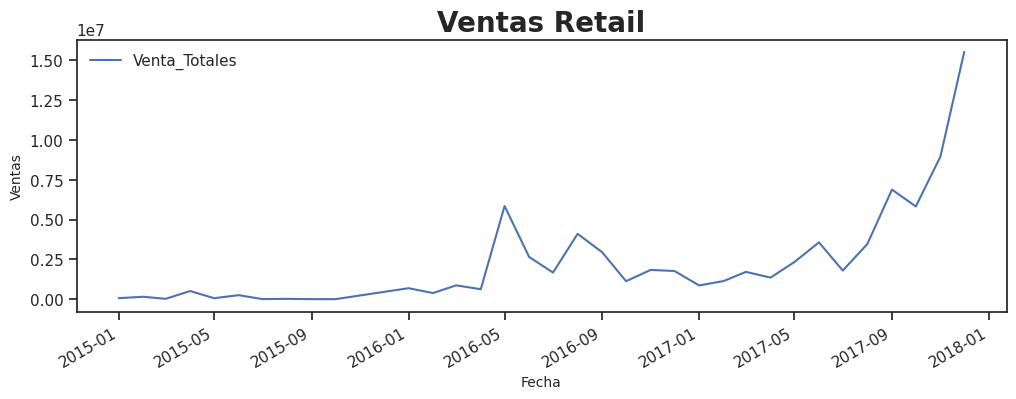

In [ ]:
# Ploteo de Series de Tiempo de la Variable
# ==============================================================================
datos.plot(figsize=(12, 4))
plt.legend(loc ='best')
plt.title('Ventas Retail', fontweight='bold', size=20)
plt.xlabel('Fecha', fontsize=10)
plt.ylabel('Ventas', fontsize=10)
plt.show(block=False)

In [ ]:
# Verificamos si hay datos nulos
# ==============================================================================
datos.isnull().sum()

,0
Venta_Totales,0


<font color=green> No faltan valores

### <font color=blue> Dividir los datos de series temporales en conjuntos de entrenamiento y prueba

In [ ]:
# Realice la división de prueba de train para ese segmento de mercado que toma los datos de 34 meses como datos del train y
# Los datos de 6 meses como datos de prueba.
# ==============================================================================
train_len = 28
train = datos[0:train_len] # Primeros 28 meses como conjunto de entrenamiento
test = datos[train_len:] # Últimos 6 meses como conjunto de prueba fuera de tiempo

### <font color=blue> Descomposición de Series Temporales

Comprendamos cómo se puede dividir una serie de tiempo en sus diversos componentes, es decir, tendencia, estacionalidad y residuos.

### **Descomposición Estacional Aditiva**

Los componentes individuales se pueden agregar para obtener los datos de series de tiempo.

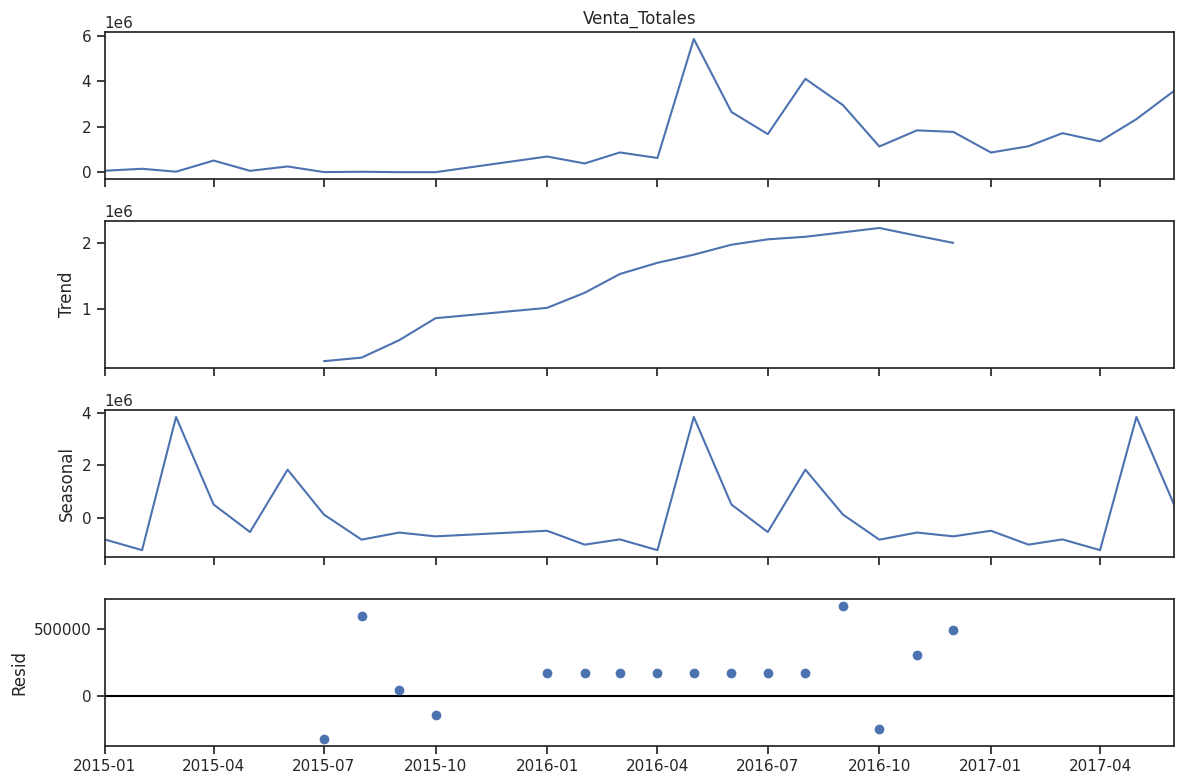

In [ ]:
# Descomposición Estacional
# ==============================================================================
rcParams['figure.figsize'] = 12, 8

# Verificamos si 'train.Venta_Totales' tiene un índice de fecha y hora
if not isinstance(train.index, pd.DatetimeIndex):
    # Caso contrario, convertimos el índice a fecha y hora.
    train.index = pd.to_datetime(train.index)

# Establecemos frecuencia en Inicio del mes
train.Venta_Totales = train.Venta_Totales.asfreq('MS')

# Realizar descomposición estacional.
# Por ejemplo, si sus datos tienen una estacionalidad anual, puede establecer el período = 12
descomposicion = sm.tsa.seasonal_decompose(train.Venta_Totales, model='additive', period=12) # Período agregado=12

# Trazo de la descomposición
fig = descomposicion.plot()
plt.show()

### **Descomposición Estacional Multiplicativa**

Los componentes individuales se pueden multiplicar para obtener los datos de series de tiempo.

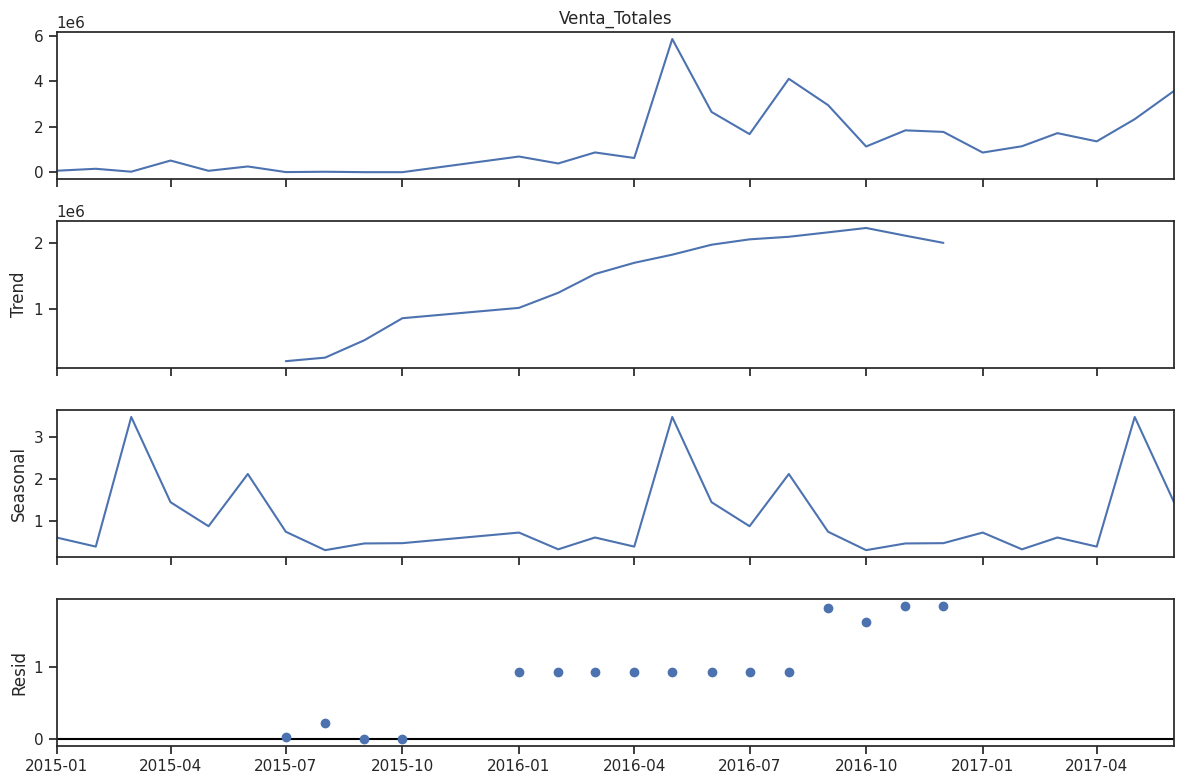

In [ ]:
# Descomposición Multiplicativa
# ==============================================================================
descomposicion2 = sm.tsa.seasonal_decompose(train.Venta_Totales, model='multiplicative', period=12) # Índice estacional multiplicativo
fig = descomposicion2.plot()
plt.show()

# <font color=purple><strong> Construir y Evaluar Pronósticos de Series Temporales

Dividimos los datos de series temporales en conjuntos de entrenamiento y prueba

In [ ]:
# Realice la división de prueba de train para ese segmento de mercado que toma los datos de 34 meses como datos del train y
# Los datos de 6 meses como datos de prueba.
# ==============================================================================
train_len = 28
train = datos[0:train_len] # Primeros 28 meses como conjunto de entrenamiento
test = datos[train_len:] # Últimos 6 meses como conjunto de prueba fuera de tiempo

## <font color=blue> Métodos Simples de Series de Tiempo.

### <font color=blue> Método Naive
    
    Previsión = Ventas del último mes

In [ ]:
# Forecast del último mes
# ==============================================================================
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Venta_Totales'][train_len-1] # Última observación en los datos del train

### Plot del train, Probamos y Pronosticamos

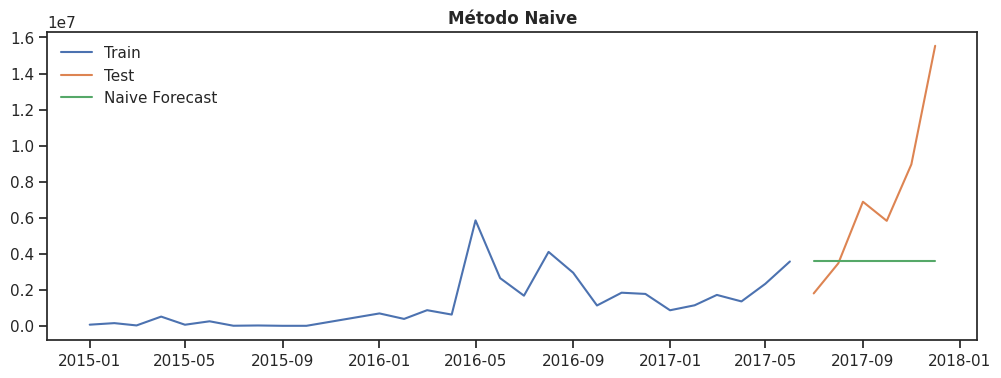

In [ ]:
# Plot del último mes de Pronóstico
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast')
plt.legend(loc='best')
plt.title('Método Naive', fontweight= 'bold')
plt.show()

- <font color=green> Como podemos ver en el gráfico, para pronosticar las ventas del mes 2017-05 al 2018-01, utilizamos los datos del último mes o del anterior, que es 2017-04.
- <font color=green> Podemos ver que el pronóstico para los próximos 6 meses tiene el mismo valor (línea verde) que la última observación de la línea azul.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_naive['naive_forecast'])/test['Venta_Totales'])*100,2)

resultados = pd.DataFrame({'Metodo':['Metodo Naive'], 'MAPE': [mape], 'RMSE': [rmse]})
resultados = resultados[['Metodo', 'RMSE', 'MAPE']]
resultados

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24


### <font color=blue> **Método de Promedio Simple**

**Pronóstico = Promedio de ventas de todos los meses anteriores**

In [ ]:
# Pronóstico Promedio Simple
# ==============================================================================
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Venta_Totales'].mean() # Promedio de ventas de los últimos meses

### Plot del train, Probamos y Pronosticamos

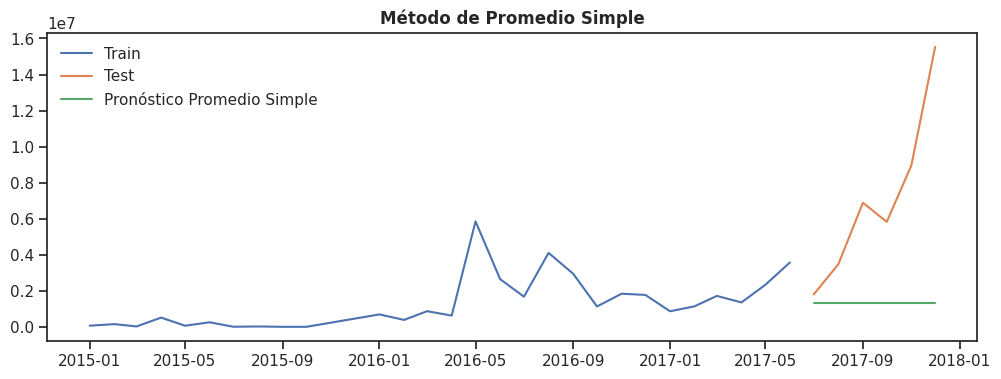

In [ ]:
# Pronóstico Promedio Simple de todos los meses
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Pronóstico Promedio Simple')
plt.legend(loc='best')
plt.title('Método de Promedio Simple', fontweight='bold')
plt.show()

- <font color=green> Pronóstico de los meses de 2017-05 al 2018-01 = Promedio de ventas de todos los meses anteriores
- <font color=green> La línea verde es el promedio de todos los datos de ventas de 28 meses.
- <font color=green> La línea verde que pronosticamos no muestra ninguna tendencia ni estacionalidad, mientras que nuestros datos de train y prueba, tenían tanto tendencia como estacionalidad.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_avg['avg_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_avg['avg_forecast'])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método de Promedio Simple'], 'RMSE': [rmse],'MAPE': [mape] })
resultados2 = pd.concat([resultados, tempResults])
resultados2 = resultados2[['Metodo', 'RMSE', 'MAPE']]
resultados2

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89


### <font color=blue> **Método de Media Móvil Simple**

**Pronóstico = Promedio de sólo las últimas observaciones para pronosticar el futuro**
 - Reduce el ruido no sistemático en los datos.

In [ ]:
# Promedio de las 3 últimos meses
# ==============================================================================
y_hat_sma = datos.copy()
ma_window = 3  # Se considera una ventana de 3 meses
y_hat_sma['sma_forecast'] = datos['Venta_Totales'].rolling(ma_window).mean()
y_hat_sma['sma_forecast'][train_len:] = y_hat_sma['sma_forecast'][train_len-1]

### Plot del train, Probamos y Pronosticamos

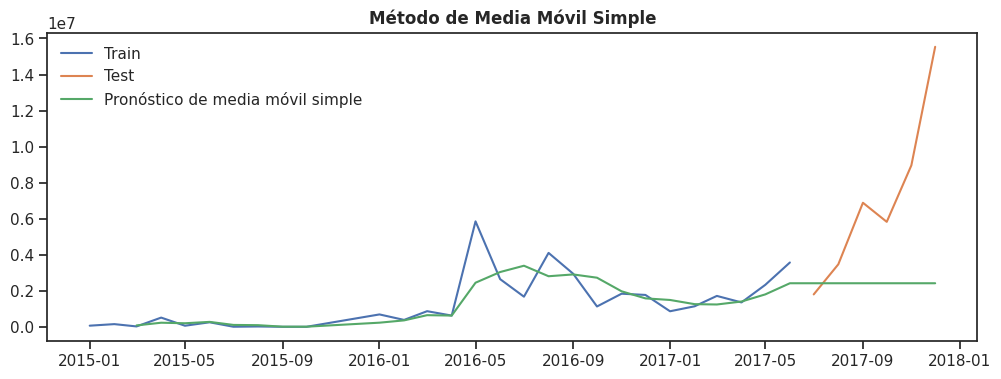

In [ ]:
# Pronóstico de la Media Móvil Simple
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_sma['sma_forecast'], label='Pronóstico de media móvil simple')
plt.legend(loc='best')
plt.title('Método de Media Móvil Simple', fontweight= 'bold')
plt.show()

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_sma['sma_forecast'][train_len:])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_sma['sma_forecast'][train_len:])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Pronóstico de Media Móvil Simple'], 'RMSE': [rmse],'MAPE': [mape] })
resultados3 = pd.concat([resultados2, tempResults])
resultados3 = resultados3[['Metodo', 'RMSE', 'MAPE']]
resultados3

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60


## <font color=blue> **Métodos de Suavizado Exponencial**

### <font color=blue> **Suavizado Exponencial Simple**

- **La demanda del período más reciente multiplicada por el factor de suavizado.**
- Es un método de predicción de series temporales para datos univariados sin tendencia ni estacionalidad.
- El modelo exponencial simple captura el nivel de una serie temporal.

In [ ]:
# Método de Suavizado Simple con un factor = 6
# ==============================================================================
model = SimpleExpSmoothing(train['Venta_Totales'])
model_fit = model.fit(optimized=True)
model_fit.params
y_hat_ses = test.copy()
y_hat_ses['ses_forecast'] = model_fit.forecast(6)

### Plot del train, Probamos y Pronosticamos

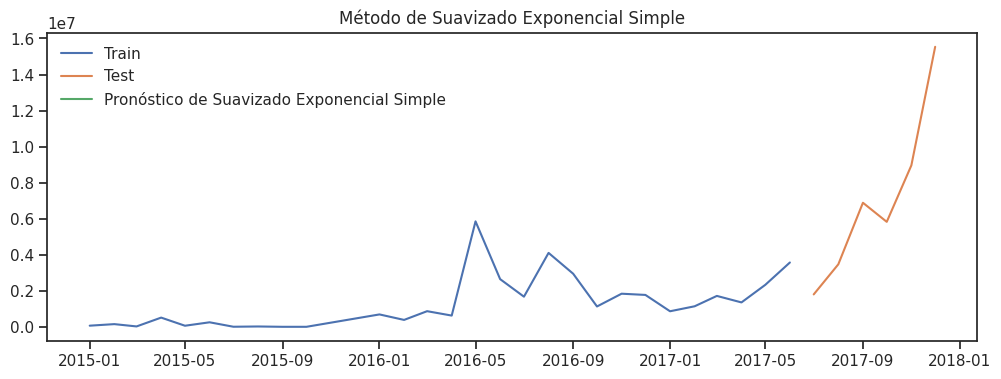

In [ ]:
# Pronóstico del Método de Suavizado Simple
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Pronóstico de Suavizado Exponencial Simple')
plt.legend(loc='best')
plt.title('Método de Suavizado Exponencial Simple')
plt.show()

<font color=green> Podemos ver que el modelo exponencial simple capturó el nivel de una serie de tiempo.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
# Verificamos los valores de NaN en ambas columnas
print(f"Valores de NaN en test['Venta_Totales']: {test['Venta_Totales'].isnull().sum()}")
print(f"Valores de NaN en y_hat_ses['ses_forecast']: {y_hat_ses['ses_forecast'].isnull().sum()}")

# Si existen valores de NaN, (por ejemplo, reemplácelos con media, mediana o 0)
# Ejemplo: reemplazar NaN por 0
test['Venta_Totales'].fillna(0, inplace=True)
y_hat_ses['ses_forecast'].fillna(0, inplace=True)

# Hasta aqui si no tuviese "NaN"
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_ses['ses_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_ses['ses_forecast'])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Pronóstico de Suavizado Exponencial Simple'], 'RMSE': [rmse],'MAPE': [mape] })
resultados4 = pd.concat([resultados3, tempResults])
resultados4

Valores de NaN en test['Venta_Totales']: 0
Valores de NaN en y_hat_ses['ses_forecast']: 6


,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00


### <font color=blue> **Suavizado Exponencial de Holt**

- Captura tanto el nivel como la tendencia de una serie temporal en el pronóstico.

In [ ]:
# Metodo de Holt
# ==============================================================================
model = ExponentialSmoothing(np.asarray(train['Venta_Totales']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(smoothing_level=0.2, smoothing_slope=0.01, optimized=False)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.2, 'smoothing_trend': 0.01, 'smoothing_seasonal': None, 'damping_trend': nan, 'initial_level': 206531.19999999984, 'initial_trend': -17857.72854545453, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot del train, Probamos y Pronosticamos

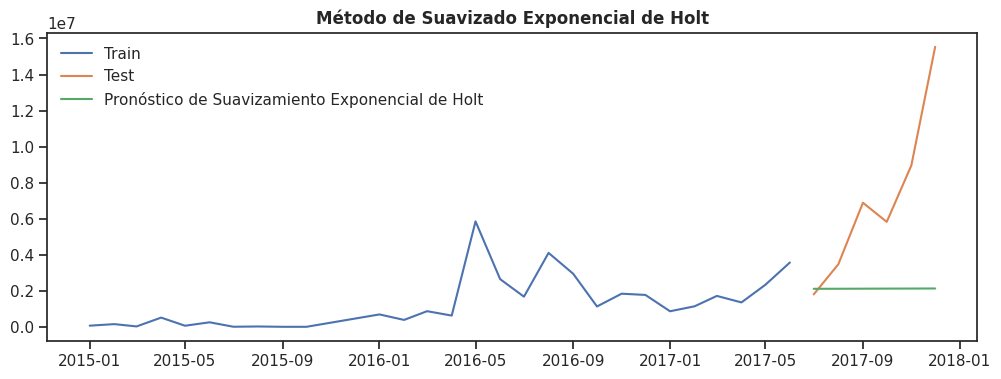

In [ ]:
# Pronóstico del Método de Holt
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot( train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Pronóstico de Suavizamiento Exponencial de Holt')
plt.legend(loc='best')
plt.title('Método de Suavizado Exponencial de Holt', fontweight='bold')
plt.show()

<font color=green> Podemos ver que el pronóstico es una línea recta, con pendiente ascendente ya que el método de Holt captura tanto el nivel como la tendencia.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_holt['holt_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_holt['holt_forecast'])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método de suavizado exponencial de Holt'], 'RMSE': [rmse],'MAPE': [mape] })
resultados5 = pd.concat([resultados4, tempResults])
resultados5 = resultados5[['Metodo', 'RMSE', 'MAPE']]
resultados5

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64


### <font color=blue> **El Método aditivo de Holt-Winters con Tendencia y Estacionalidad**

**Proyecciones basadas en el nivel, la tendencia y la estacionalidad de una serie temporal**

In [ ]:
# Método de Holt-Winters
# ==============================================================================
y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Venta_Totales']) ,seasonal_periods=12 ,trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.2525, 'smoothing_trend': 0.07214285714285715, 'smoothing_seasonal': 0.20929999999999999, 'damping_trend': nan, 'initial_level': -43744.54233333317, 'initial_trend': 210570.3914015152, 'initial_seasons': array([ -791525.45260417, -1204003.66385417,  3901079.82239583,
         545181.5915625 ,  -509432.03135417,  1881698.12114583,
        -340037.2859375 ,  -378713.82510417,  -659594.8309375 ,
        -991463.05552083,  -460567.3021875 ,  -992622.08760417]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot del train, Probamos y Pronosticamos

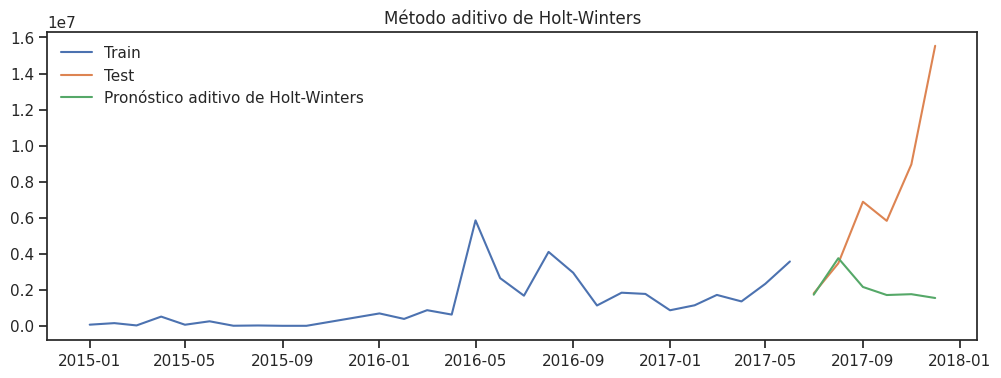

In [ ]:
# Pronóstico del Método de Holt-Winter
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot( train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Pronóstico aditivo de Holt-Winters')
plt.legend(loc='best')
plt.title('Método aditivo de Holt-Winters')
plt.show()

<font color=green> Podemos ver que podemos capturar una buena cantidad de variación estacional e incluso la tendencia.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_hwa['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_hwa['hw_forecast'])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método aditivo de Holt-Winters'], 'RMSE': [rmse],'MAPE': [mape] })
resultados6 = pd.concat([resultados5, tempResults])
resultados6 = resultados6[['Metodo', 'RMSE', 'MAPE']]
resultados6

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65


<font color=green> Podemos ver que el método aditivo de Holt-Winter tiene los valores RMSE y MAPE más bajos. Lo que significa que las medidas de error son muy menores en este modelo.

### <font color=blue> **Método Multiplicativo de Holt-Winter con Tendencia y Estacionalidad**

**Pronóstico= Multiplica el pronóstico de tendencia por la estacionalidad**

In [ ]:
# Método Multiplicativo de Holt-Winters
# ==============================================================================
y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Venta_Totales']) ,seasonal_periods=12 ,trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 0.005, 'smoothing_trend': 0.0001, 'smoothing_seasonal': 0.5330357142857143, 'damping_trend': nan, 'initial_level': 0.01, 'initial_trend': 210570.3914015152, 'initial_seasons': array([7.28503670e-01, 4.71774911e-01, 4.12592916e+00, 1.72340215e+00,
       1.04627994e+00, 2.51864830e+00, 2.70859878e-02, 9.19723166e-02,
       2.18101949e-03, 1.34024377e-03, 8.67642911e-01, 3.95239390e-01]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


### Plot del train, Probamos y Pronosticamos

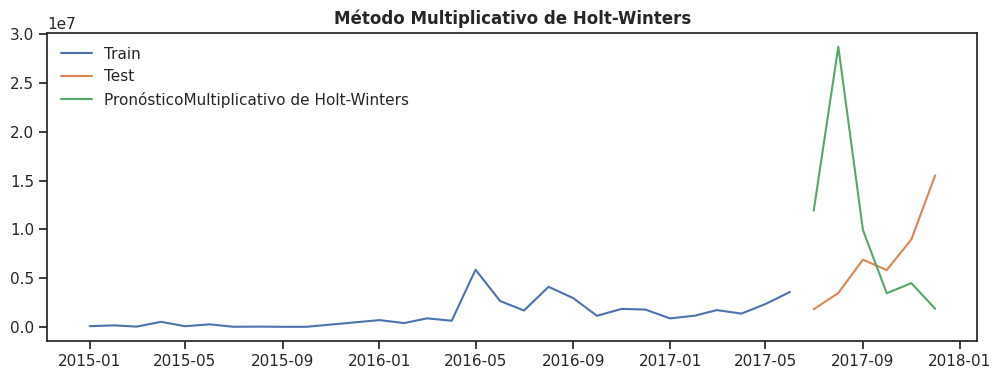

In [ ]:
# Pronóstico del Método Multiplicativo de Holt-Winter
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot( train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label='PronósticoMultiplicativo de Holt-Winters')
plt.legend(loc='best')
plt.title('Método Multiplicativo de Holt-Winters', fontweight='bold')
plt.show()

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_hwm['hw_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_hwm['hw_forecast'])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método Multiplicativo de Holt-Winters'], 'RMSE': [rmse],'MAPE': [mape] })
resultados7 = pd.concat([resultados6, tempResults])
resultados7 = resultados7[['Metodo', 'RMSE', 'MAPE']]
resultados7

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65
0,Método Multiplicativo de Holt-Winters,12664000.54,252.18


- De las técnicas de alisado realizadas podemos concluir que el método aditivo de Holt-Winter está dando la mejor previsión de ventas para los 6 meses, ya que las ventas previstas se acercan más a las ventas reales.
- También pudimos ver que los valores RMSE y MAPE son los menores entre todos los métodos realizados anteriormente.

## <font color=blue> **Métodos Autoregresivos**

En un modelo autorregresivo, la técnica de regresión se utiliza para formular un problema de series de tiempo. Para implementar modelos autorregresivos, pronosticamos observaciones futuras utilizando una combinación lineal de observaciones pasadas de la misma variable.

### Estacionariedad versus Series Temporales NO Estacionarias

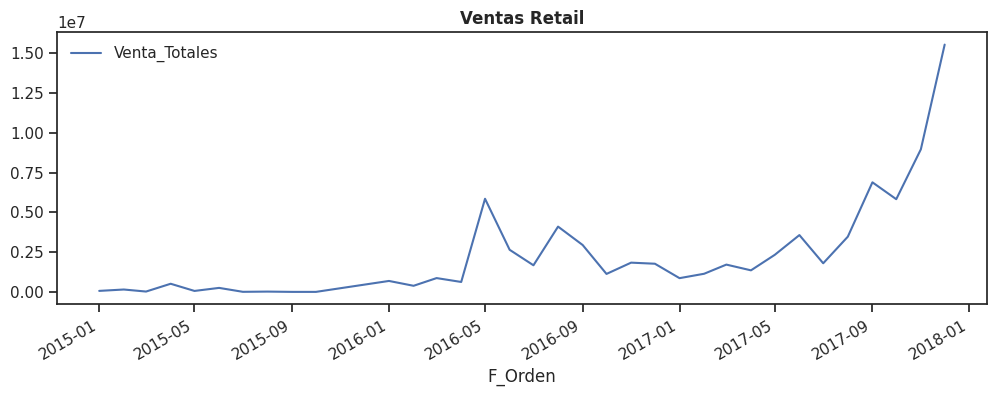

In [ ]:
# Estacionariedad Vs No Estacionariedad
# ==============================================================================
#plt.figure(figsize=(12,4))
datos['Venta_Totales'].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('Ventas Retail', fontweight='bold')
plt.show(block=False)

### <font color=blue> **Prueba Dickey-Fuller aumentada (ADF)**

Hipótesis Nula $(H_0)$: La serie no es estacionaria $p-value > 0.05 $

Hipótesis Alternativa$(H_1)$: La serie es estacionaria $p-value <= 0.05 $

In [ ]:
# Método de Dickey-Fuller
# ==============================================================================
adf_test = adfuller(datos['Venta_Totales'])

print('ADF Estadístico: %f' % adf_test[0])
print('Valores críticos @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Estadístico: 3.128661
Valores críticos @ 0.05: -2.96
p-value: 1.000000


- <font color=brown> Podemos ver que el valor p es 1.000, que es mayor que 0,05.
- <font color=brown> Entonces la serie es No estacionaria. Y Aceptamos la hipótesis nula $(H_0)$

### <font color=blue> **Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**

Hipótesis Nula $(H_0)$: La serie es estacionaria $p-value > 0.05 $

Hipótesis Alternativa $(H_1)$: La serie no es estacionaria $p-value <= 0.05 $

In [ ]:
# Método Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
# ==============================================================================
kpss_test = kpss(data['Venta_Totales'])

print('KPSS Estadístico: %f' % kpss_test[0])
print('Valores críticos @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Estadístico: 7.505858
Valores críticos @ 0.05: 0.46
p-value: 0.010000


- <font color=brown> p-value es 0.010 < 0.05
- <font color=brown> Lo que significa que la serie no es estacionaria.

**Las dos herramientas para convertir una serie no estacionaria en una serie estacionaria son las siguientes:**

- Diferenciación
- Transformación

### <font color=blue> **Transformación de Box-Cox para hacer que la varianza sea constante**

- **La transformación Box-Cox hace que la varianza sea constante en una serie temporal.**

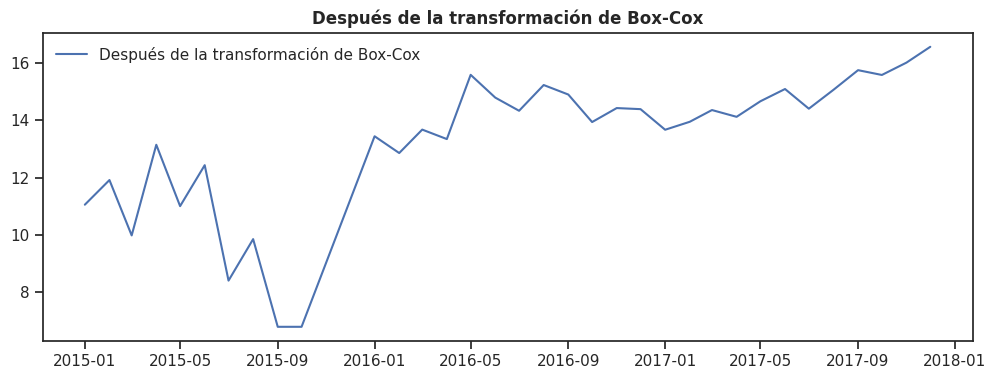

In [ ]:
# Transformación de Box-Cox
# ==============================================================================
data_boxcox = pd.Series(boxcox(datos['Venta_Totales'], lmbda=0), index = datos.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='Después de la transformación de Box-Cox')
plt.legend(loc='best')
plt.title('Después de la transformación de Box-Cox', fontweight= 'bold')
plt.show()

### <font color=purple> **Diferenciación para eliminar tendencia**

- **La diferenciación se realiza restando la observación anterior de la observación actual.**
- **La diferenciación puede eliminar tanto la tendencia como la estacionalidad en una serie temporal.**

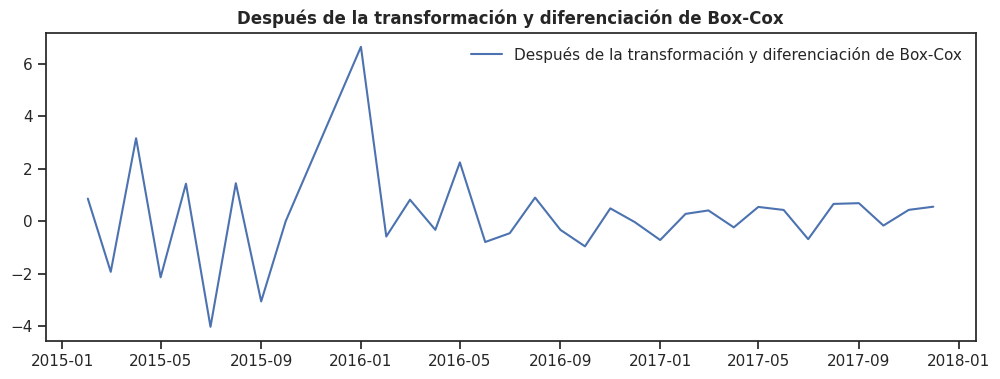

In [ ]:
# Diferenciación de la Tendencia
# ==============================================================================
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), datos.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='Después de la transformación y diferenciación de Box-Cox')
plt.legend(loc='best')
plt.title('Después de la transformación y diferenciación de Box-Cox', fontweight='bold')
plt.show()

- <font color=green> La serie parece estacionaria.
- <font color=green> Las fluctuaciones están bajo límites constantes.
- <font color=green> La media también está centrada alrededor de cero.

In [ ]:
# Diferenciaciones
# ==============================================================================
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff.tail()

,0
F_Orden,
2017-08-01,0.657212
2017-09-01,0.685260
2017-10-01,-0.167214
2017-11-01,0.430407
2017-12-01,0.550775


### <font color=blue> **Prueba Dickey-Fuller aumentada (ADF)**

In [ ]:
# Test de Dickey-Fuller
# ==============================================================================
adf_test = adfuller(data_boxcox_diff)

print('ADF Estadístico: %f' % adf_test[0])
print('Valores críticos @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Estadístico: -2.512175
Valores críticos @ 0.05: -2.99
p-value: 0.112540


- <font color=brown> p-value es 0.1125 > 0.05, Aceptamos la hipótesis nula $(H_0)$
- <font color=brown> La serie es No Estacionaria.

### <font color=blue> **Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**

In [ ]:
# Test de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
# ==============================================================================
kpss_test = kpss(data_boxcox_diff)

print('KPSS Estadístico: %f' % kpss_test[0])
print('Valores críticos @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Estadístico: 0.052334
Valores críticos @ 0.05: 0.46
p-value: 0.100000


- <font color=brown> p-value es 0.100 >= 0.05, No rechazar la hipótesis nula $(H_0)$
- <font color=brown> La serie es estacionaria.

<font color=blue> Así, después de realizar las pruebas de estacionariedad podemos ver que podemos convertir una serie no estacionaria en una serie estacionaria para construir un modelo autoregresivo.

### <font color=blue> **Función de Autocorrelación (ACF)**

- La correlación de las observaciones de la serie temporal con valores de la misma serie en momentos anteriores (retrasos) se denomina Autocorrelación.
- ACF describe la Autocorrelación entre una observación y otra observación en un paso de tiempo anterior que incluye información de dependencia directa e indirecta.

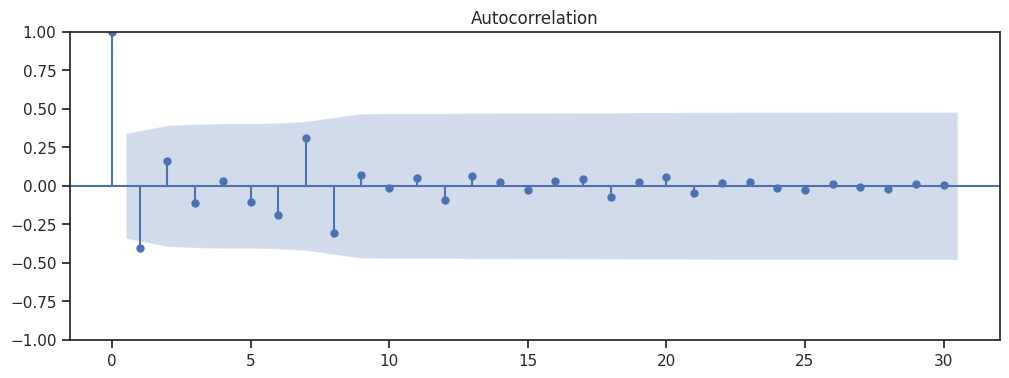

In [ ]:
# Autocorrelación
# ==============================================================================
plt.figure(figsize=(12,4))
plot_acf(data_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()


### <font color=blue> **Función de Autocorrelación Parcial (PACF)**

- El PACF sólo describe la relación directa entre una observación y su desfase.

In [ ]:
# Autocorrelación Parcial (PACF)
# ==============================================================================
#plt.figure(figsize=(12,4))
#plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = 30)
#plt.show()

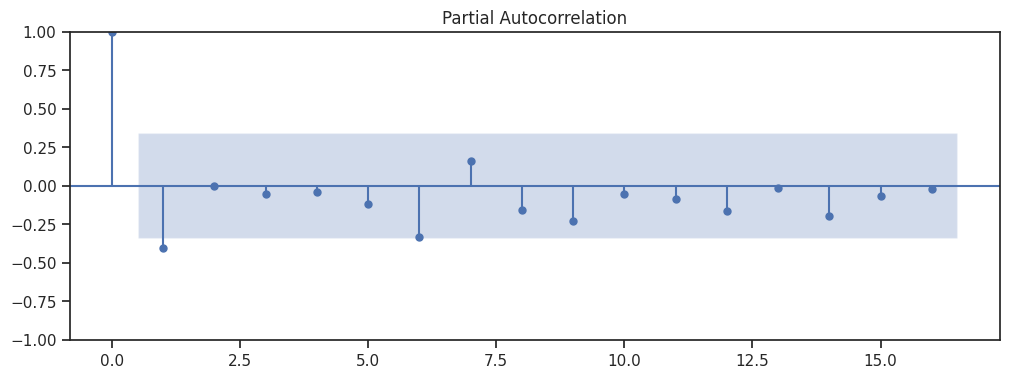

In [ ]:
# Autocorrelación Parcial (PACF)
# ==============================================================================
plt.figure(figsize=(12,4))

# Calcular el retraso máximo permitido
max_lag = len(data_boxcox_diff) // 2

# Utilizamos un valor de retraso que sea menor o igual al retraso máximo
plot_pacf(data_boxcox_diff, ax=plt.gca(), lags = min(30, max_lag))
plt.show()

In [ ]:
# Pruebas de Entrenamiento
# ==============================================================================
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

<font color=blue> Usaremos directamente p=1, q=1 y d=1 ya que los pronósticos son relativamente mejores para estos valores.

## <font color=blue> **Método de Regresión Automática (AR)**

- Modela la observación futura como una regresión lineal de una o más observaciones pasadas.
- El parámetro del modelo autorregresivo 'p' se calcula a partir del gráfico de la función de autocorrelación parcial.
- Seleccione "p" como el retraso más alto donde la autocorrelación parcial es significativamente alta.

In [ ]:
# Método ARIMA
# ==============================================================================
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.params)

const     0.138734
ar.L1    -0.394586
sigma2    3.164478
dtype: float64


### **Recuperar Series Temporales Originales**

In [ ]:
# Series Temporales Originales
# ==============================================================================
y_hat_ar = data_boxcox_diff.copy()
# Los valores inicial y final deben estar en el índice de train_data_boxcox_diff
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(train_data_boxcox_diff.index.min(), train_data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

### Plot del train, Probamos y Pronosticamos

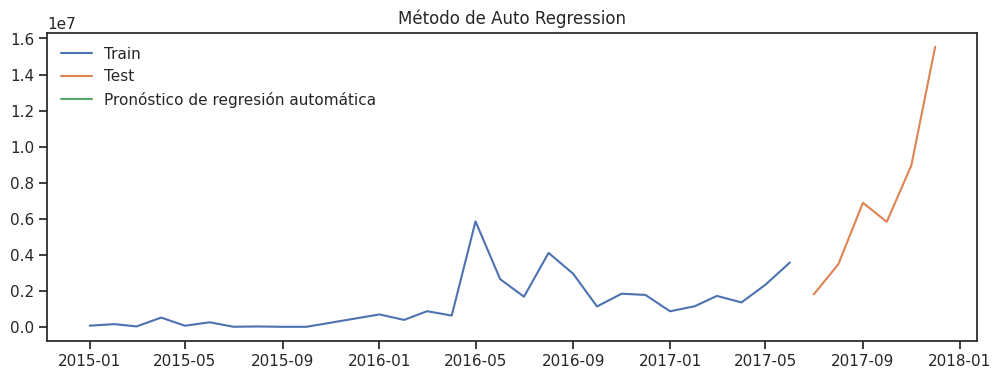

In [ ]:
# Pronóstico con Autoregresion
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Pronóstico de regresión automática')
plt.legend(loc='best')
plt.title('Método de Auto Regression')
plt.show()

<font color=green> En el gráfico podemos ver que podemos capturar la tendencia en el pronóstico pero no pudimos capturar la estacionalidad.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
# Aseguramos de que los valores pronosticados tengan el mismo índice que los datos de prueba.
forecasted_values = y_hat_ar['ar_forecast'][test.index.min():].reindex(test.index)

# Verificamos y maneje valores NaN en 'Venta_Totales' y 'forecasted_values'
test['Venta_Totales'].fillna(0, inplace=True)  # Reemplace NaN con 0 en 'Venta_Totales'
forecasted_values.fillna(0, inplace=True)  # Reemplace NaN con 0 en 'valores_pronósticos'


rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], forecasted_values)).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-forecasted_values)/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método autorregresivo (AR)'], 'RMSE': [rmse],'MAPE': [mape] })
resultados8 = pd.concat([resultados7, tempResults])
resultados8 = resultados8[['Metodo', 'RMSE', 'MAPE']]
resultados8

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65
0,Método Multiplicativo de Holt-Winters,12664000.54,252.18
0,Método autorregresivo (AR),8349916.45,100.00


<font color=green> Los valores RMSE y MAPE vuelven a ser altos.

### <font color=blue> **Método de Media Móvil (MA)**

- El modelo de media móvil modela los pronósticos futuros utilizando errores de pronóstico pasados ​​en un modelo similar a una regresión.
- Este modelo tiene un parámetro 'q' llamado tamaño de ventana sobre el cual se calcula la combinación lineal de errores.
- "q" se calcula a partir del gráfico de la función de autocorrelación. Seleccione "q" como el retraso más alto más allá del cual la autocorrelación disminuye.

In [ ]:
# Método ARIMA con MA (0, 0, 1)
# ==============================================================================
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.140337
ma.L1    -0.384556
sigma2    3.220371
dtype: float64


### **Recuperar series temporales originales**

In [ ]:
# Diferenciación
# ==============================================================================
y_hat_ma = data_boxcox_diff.copy()
# Los valores iniciales deben estar en el índice de train_data_boxcox_diff
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(train_data_boxcox_diff.index.min(), train_data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

### Plot del train, Probamos y Pronosticamos

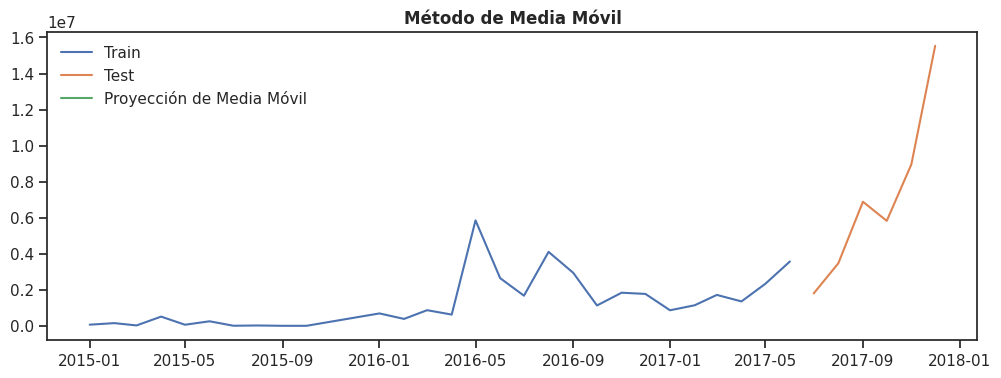

In [ ]:
# Pronósticos con Media Móvil (MA)
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(datos['Venta_Totales'][:train_len], label='Train')
plt.plot(datos['Venta_Totales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Proyección de Media Móvil')
plt.legend(loc='best')
plt.title('Método de Media Móvil', fontweight='bold')
plt.show()

<font color=green> Podemos capturar la tendencia pero no la estacionalidad en el pronóstico.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
# Aseguramos de que los valores pronosticados tengan el mismo índice que los datos de prueba.
forecasted_values = y_hat_ma['ma_forecast'][test.index.min():].reindex(test.index)

# Verificamos y maneje valores NaN en 'Venta_Totales' y 'forecasted_values'
test['Venta_Totales'].fillna(0, inplace=True)  # Reemplace NaN con 0 en 'Venta_Totales'
forecasted_values.fillna(0, inplace=True)  # Reemplace NaN con 0 en 'valores_pronósticos'

# Asegúrese de que los valores previstos se divida correctamente utilizando el índice de prueba
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], forecasted_values)).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-forecasted_values)/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método de Media Móvil (MA)'], 'RMSE': [rmse],'MAPE': [mape] })
resultados9 = pd.concat([resultados8, tempResults])
resultados9 = resultados9[['Metodo', 'RMSE', 'MAPE']]
resultados9

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65
0,Método Multiplicativo de Holt-Winters,12664000.54,252.18
0,Método autorregresivo (AR),8349916.45,100.00
0,Método de Media Móvil (MA),8349916.45,100.00


<font color=green> Los valores RMSE y MAPE son altos, lo que significa demasiados errores.

### <font color=blue> **Método de Media Móvil de Regresión Automática (ARMA)**

- Una serie de tiempo que exhibe las características de un proceso $AR(p)$ y/o $MA(q)$ se puede modelar usando un modelo $ARMA(p,q)$
- Modela la observación futura como una regresión lineal de una o más observaciones pasadas y errores de pronóstico pasados.

In [ ]:
# Indicadores
# ==================================================
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.params)

const     0.138245
ar.L1    -0.446061
ma.L1     0.061629
sigma2    3.163125
dtype: float64


### **Recuperar series temporales originales**

In [ ]:
# Diferenciación
# ==============================================================================
#y_hat_arma = data_boxcox_diff.copy()
#y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(train_data_boxcox_diff.index.min(), train_data_boxcox_diff.index.max())
#y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
#y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
#y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

In [ ]:
# Diferenciación
# ==============================================================================
y_hat_arma = data_boxcox_diff.copy()
# Use the index of train_data_boxcox_diff for prediction
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(start=train_data_boxcox_diff.index.min(), end=train_data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

### Plot del train, Probamos y Pronosticamos

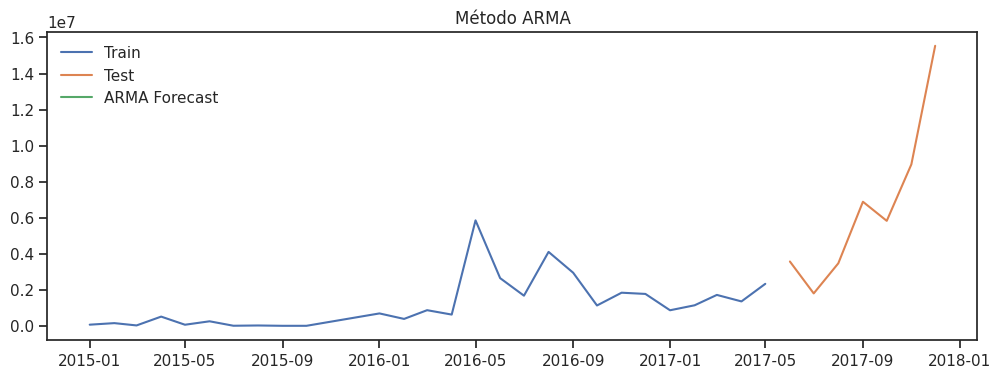

In [ ]:
# Pronósticos con Media Móvil (ARMA)
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot( datos['Venta_Totales'][:train_len-1], label='Train')
plt.plot(datos['Venta_Totales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA Forecast')
plt.legend(loc='best')
plt.title('Método ARMA')
plt.show()

<font color=green> El modelo ARMA capturó la tendencia pero no la estacionalidad.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
# Aseguramos de que los valores pronosticados tengan el mismo índice que los datos de prueba.
forecasted_values = y_hat_arma['arma_forecast'][test.index.min():].reindex(test.index)

# Verificamos y maneje valores NaN en 'Venta_Totales' y 'forecasted_values'
test['Venta_Totales'].fillna(0, inplace=True)  # Reemplace NaN con 0 en 'Venta_Totales'
forecasted_values.fillna(0, inplace=True)  # Reemplace NaN con 0 en 'valores_pronósticos'

# Ensure the forecasted values are sliced correctly to match the test data
# Use boolean indexing to select values from y_hat_arma that have corresponding indices in test
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], y_hat_arma[test.index])).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-y_hat_arma[test.index])/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método de media móvil autorregresiva (ARMA)'], 'RMSE': [rmse],'MAPE': [mape] })
resultados10 = pd.concat([resultados9, tempResults])
resultados10 = resultados10[['Metodo', 'RMSE', 'MAPE']]
resultados10

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65
0,Método Multiplicativo de Holt-Winters,12664000.54,252.18
0,Método autorregresivo (AR),8349916.45,100.00
0,Método de Media Móvil (MA),8349916.45,100.00
0,Método de media móvil autorregresiva (ARMA),8349916.11,100.00


<font color=green> Podemos ver valores altos de MAPE y RMSE.

### <font color=blue> **Media móvil integrada regresiva automática (ARIMA)**

- El modelo ARIMA tiene tres parámetros.
- p: Rezago más alto incluido en el modelo de regresión
- d: Grado de diferenciación para hacer la serie estacionaria
- q: Número de términos de error pasados ​​incluidos en el modelo de regresión


- 'd' es el parámetro de diferenciación. Si "d" es 1, eso significa que la serie ahora tiene pendiente 0 y por lo tanto no tendrá tendencia. Es decir, la serie temporal inicialmente tenía tendencia.

In [ ]:
# Indicadores
# ==================================================
model = ARIMA(train_data_boxcox, order=(1, 1, 1))# p,d,q
model_fit = model.fit()
print(model_fit.params)

ar.L1    -0.474559
ma.L1     0.101745
sigma2    3.197655
dtype: float64


### **Recuperar series temporales originales**

In [ ]:
# Diferenciación
# ==================================================
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(start=train_data_boxcox_diff.index.min(), end=train_data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

### Plot del train, Probamos y Pronosticamos

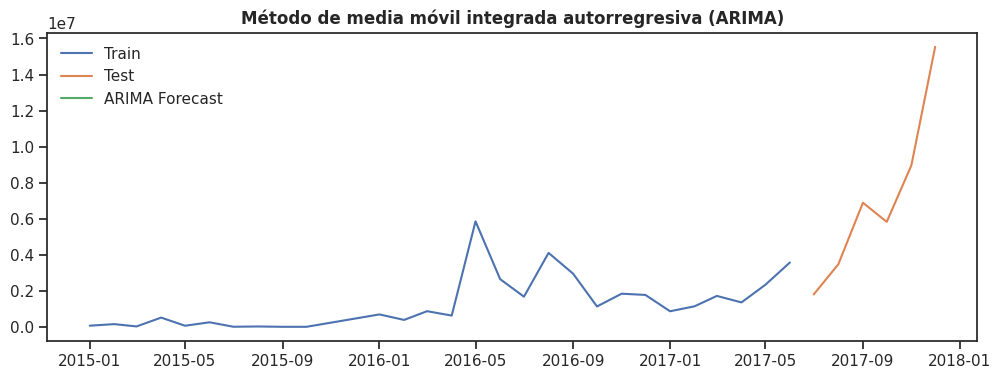

In [ ]:
# Pronósticos con Media Móvil (ARIMA)
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA Forecast')
plt.legend(loc='best')
plt.title('Método de media móvil integrada autorregresiva (ARIMA)', fontweight='bold')
plt.show()

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
# Aseguramos de que los valores pronosticados tengan el mismo índice que los datos de prueba.
forecasted_values = y_hat_arima['arima_forecast'][test.index.min():].reindex(test.index)

# Verificamos y maneje valores NaN en 'Venta_Totales' y 'forecasted_values'
test['Venta_Totales'].fillna(0, inplace=True)  # Reemplace NaN con 0 en 'Venta_Totales'
forecasted_values.fillna(0, inplace=True)  # Reemplace NaN con 0 en 'valores_pronósticos'

# Ensure the forecasted values have the same length as the test data
forecasted_values = forecasted_values.iloc[:len(test)]

rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], forecasted_values)).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-forecasted_values)/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['Método de Media Móvil integrada Autorregresiva (ARIMA)'], 'RMSE': [rmse],'MAPE': [mape] })
resultados11 = pd.concat([resultados10, tempResults])
resultados11 = resultados11[['Metodo', 'RMSE', 'MAPE']]
resultados11

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65
0,Método Multiplicativo de Holt-Winters,12664000.54,252.18
0,Método autorregresivo (AR),8349916.45,100.00
0,Método de Media Móvil (MA),8349916.45,100.00
0,Método de media móvil autorregresiva (ARMA),8349916.11,100.00


### <font color=blue> **Media móvil integrada autoregresiva estacional (SARIMA)**

- El modelo SARIMA tiene elementos estacionales y no estacionales.
- SARIMA ofrece todas las características de un modelo ARIMA con una característica adicional: la estacionalidad.
- SARIMA tiene 6 parámetros además de la estacionalidad.

In [ ]:
# Indicadores
# ==================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.329735
ma.L1      -0.231978
ar.S.L12   -0.705751
ma.S.L12   -0.604929
sigma2      1.694702
dtype: float64


### **Recuperar series temporales originales**

In [ ]:
# Diferenciación
# ==================================================
y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(start=train_data_boxcox_diff.index.min(), end=train_data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

### Plot del train, Probamos y Pronosticamos

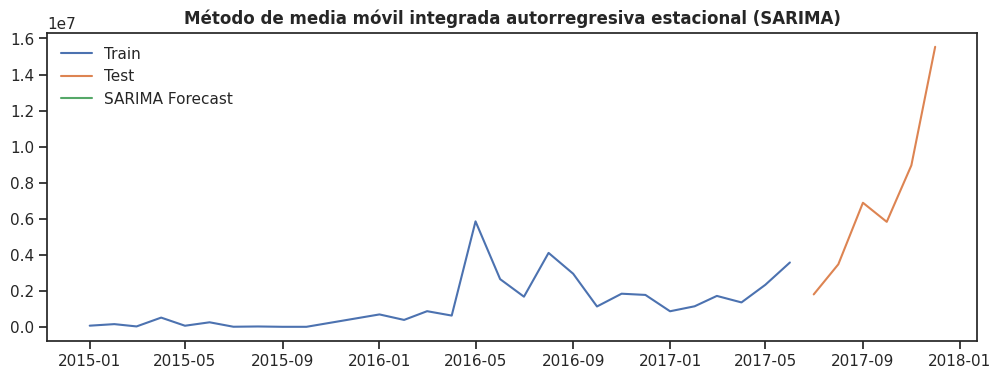

In [ ]:
# Pronósticos con SARIMA
# ==============================================================================
plt.figure(figsize=(12,4))
plt.plot(train['Venta_Totales'], label='Train')
plt.plot(test['Venta_Totales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.title('Método de media móvil integrada autorregresiva estacional (SARIMA)',fontweight='bold')
plt.show()

<font color=green> El pronóstico no captó la tendencia ni la estacionalidad.

### **Calculamos el RMSE y MAPE**

In [ ]:
# Indicadores de Error
# ==============================================================================
# Aseguramos de que los valores pronosticados tengan el mismo índice que los datos de prueba.
forecasted_values = y_hat_sarima['sarima_forecast'][test.index.min():].reindex(test.index)

# Verificamos y maneje valores NaN en 'Venta_Totales' y 'forecasted_values'
test['Venta_Totales'].fillna(0, inplace=True)  # Reemplace NaN con 0 en 'Venta_Totales'
forecasted_values.fillna(0, inplace=True)  # Reemplace NaN con 0 en 'valores_pronósticos'

#Nos aseguramos de que la longitud de 'y_hat_sarima' sea la correcta
rmse = np.sqrt(mean_squared_error(test['Venta_Totales'], forecasted_values)).round(2)
mape = np.round(np.mean(np.abs(test['Venta_Totales']-forecasted_values)/test['Venta_Totales'])*100,2)

tempResults = pd.DataFrame({'Metodo':['(SARIMA) Método de media móvil integrada autorregresiva estacional'], 'RMSE': [rmse],'MAPE': [mape] })
resultados12 = pd.concat([resultados11, tempResults])
resultados12 = resultados12[['Metodo', 'RMSE', 'MAPE']]
resultados12

,Metodo,RMSE,MAPE
0,Metodo Naive,5649836.59,54.24
0,Método de Promedio Simple,7275509.82,70.89
0,Pronóstico de Media Móvil Simple,6428990.46,57.60
0,Pronóstico de Suavizado Exponencial Simple,8349916.45,100.00
0,Método de suavizado exponencial de Holt,6645564.24,58.64
0,Método aditivo de Holt-Winters,6917784.67,53.65
0,Método Multiplicativo de Holt-Winters,12664000.54,252.18
0,Método autorregresivo (AR),8349916.45,100.00
0,Método de Media Móvil (MA),8349916.45,100.00
0,Método de media móvil autorregresiva (ARMA),8349916.11,100.00


- <font color=green> Entre todos los métodos realizados en ARIMA anterior, podemos concluir que el pronóstico realizado utilizando el método SARIMA, en nuestro caso no es capaz de predecir las ventas más cerca de los valores reales, lo cual resulta muy extraño.
- <font color=green> Los valores RMSE y MAPE para este método son iguales con el AR, MA, ARMA y Autorregresivos.

# <font color=purple> **Conclusión**

- <font color=blue> Así podemos concluir que, <font color=brown> Método aditivo de Holt Winters<font color=blue> es el mejor método de pronóstico en la técnica de suavizado.
- <font color=blue> y  <font color=brown> SARIMA - Media móvil integrada autorregresiva estacional <font color=blue> es el mejor método en el conjunto de técnicas ARIMA.